In [ ]:
%load_ext autoreload
%autoreload 2   # Change to %autoreload when development phase is over

# Table of Contents

<div id="toc"></div>

The following cell is a Javascript section of code for building the Jupyter notebook's table of content.

In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# Define working environment

**Import libraries**

In [ ]:
## Import libraries needed for setting parameters of operating system 
import os
import sys
## Import library for temporary files creation 
import tempfile 
## Import library for time management 
import time
## Import multiprocessing and functools libraries
import multiprocessing
from multiprocessing import Pool
from functools import partial
## Import pickle for transfert variable between notebooks
import pickle

In [ ]:
## Import Pandas library
import pandas as pd
## Import Numpy library
import numpy as np

In [ ]:
## Import Matplotlib 
import matplotlib as mpl 
## agg backend is used to create plot as a .png file
mpl.use('agg')
## Import Matplotlib.pyplot for creating graphs
import matplotlib.pyplot as plt 

In [ ]:
%matplotlib inline

** Add folder with SCR provided belong to this notebook**

In [ ]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

** Environment variables when working on Linux Mint **

In [ ]:
import environ_variables as envi

In [ ]:
# Set environmental variables
envi.setup_environmental_variables() 
# Display current environment variables of your computer
envi.print_environmental_variables()

** GRASS GIS Python libraries **

In [ ]:
## Import libraries needed to launch GRASS GIS in the jupyter notebook
import grass.script.setup as gsetup
## Import libraries needed to call GRASS using Python
import grass.script as gscript

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# User inputs

Here after:
- Enter the path to the directory you want to use as "[GRASSDATA](https://grass.osgeo.org/programming7/loc_struct.png)". 
- Enter the name of the location in which you want to work and its projection information in [EPSG code](http://spatialreference.org/ref/epsg/) format. Please note that the GRASSDATA folder and locations will be automatically created if not existing yet. If the location name already exists, the projection information will not be used.  
- Enter the name you want for the mapsets which will be used later for Unsupervised Segmentation Parameter Optimization (USPO), Segmentation and Classification steps.

In [ ]:
## Define a empty dictionnary for saving user inputs
user={}

In [ ]:
## Enter the path to GRASSDATA folder
user["gisdb"] = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/GRASSDATA"
## Enter the name of the location (existing or for a new one)
user["location"] = "Dakar_32628"
## Enter the EPSG code for this location 
user["locationepsg"] = "32628"
## Enter the name of the permanent mapset
user["permanent_mapset"] = "PERMANENT"
## Enter the name of a working mapset
user["dasym_mapset"] = "DASYMETRY"

In [ ]:
# Set the name of the layers
Land_cover = 'landcover'  # VHR Land cover map
Land_use = 'landuse' # VHR Land use map
mr_builtup = 'MR_builtup' # MR built-up map
mr_built_pixelvalue = '1' # The value of built pixels in the MR built-up map
## Name of the column containing the population count
population_column = "POPULATION"
## Name of the column containing the density (response variable)
response_column = "popdens"
# Define the list of columns to keep during 'rasterisation' of the vector 
list_of_columns = [population_column, response_column]
# Set a name for the empty grid layer
clumped_grid = 'clumped_grid'
# Set the resolution of the grid
tile_size = 100

In [462]:
# Name of the folder where to save all the different tests results
outputdirectory_results = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest"

** Functions defined by the user **

In [ ]:
# Import function that check existance and create GRASS GIS database folder if needed
from grass_database import check_gisdb, check_location, check_mapset, working_mapset

In [ ]:
## Import functions for processing time information
from processing_time import start_processing, print_processing_time

In [ ]:
# Import function that generate a random name in the GRASS GIS environement
from random_layer_name import random_layer_name

In [ ]:
# Import function that create color file for raster
from colorise_raster import create_color_rule

In [ ]:
# Import function that clip multiple raster according to extention of a vector layer
from create_clumped_grid import create_clumped_grid

In [ ]:
# Import function that create temp directories
from create_tempdirs import create_tempdirs

In [ ]:
# Import function that rasterise a polygon layer and save the 'gridded' version as vector
from gridded_bound import gridded_admin_boundaries

In [ ]:
# Import function that get list of class of categorical raster
from data_prep import data_prep

In [ ]:
# Import csv functions (joint etc)
import csv_func
from csv_func import ordered_list_of_path, join_2csv, join_multiplecsv

**Check for existance of GRASSDATA folder, location and mapsets**

Here after, the python script will check if GRASSDATA folder, locations and mapsets already exist. If not, they will be automatically created.

In [ ]:
# Check if the GRASS GIS database exists and create it if not
check_gisdb(user["gisdb"])

In [ ]:
# Check if the location exists and create it if not, with the CRS defined by the epsg code 
check_location(user["gisdb"],user["location"],user["locationepsg"])

In [ ]:
# Check if the mapset exists and create it if not
check_mapset(user["gisdb"],user["location"],user["permanent_mapset"])

In [ ]:
# Check if the mapset exists and create it if not
check_mapset(user["gisdb"],user["location"],user["dasym_mapset"])

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# Launch GRASS GIS working session on DASY_COVAR mapset

In [ ]:
# Change the current working GRASS GIS session mapset
working_mapset(user["gisdb"],user["location"],user["dasym_mapset"])

### Set several variables and parameter

In [ ]:
# Declare list that will contain the name/paths of temporary layers/files
TMP_BINARIES = []
TMP_MAPS = []
TMP_CSV = []

# Declare strings that will contain the log of the processing
log_text = ""
log_text_extend = ""

In [ ]:
# Set the number of job that could be runned in parallel
n_jobs = 15
# Check if the computer has enough cores
if(n_jobs >= multiprocessing.cpu_count()):
    gscript.fatal(_("Requested number of jobs is > or = to available ressources. \
                    Try to reduce to at maximum <%s> jobs")%(int(multiprocessing.cpu_count())-1))

### Create temporary directories for output

In [ ]:
# Create temporary folder and get their paths
outputdirectory_admin, outputdirectory_grid = create_tempdirs(["admin_level", "grid_level"])

# Data preparation

## Create a clumped grid for dasymetry

This grid will be the reference grid for re-allocation of population count.

In [ ]:
# Create clumped grid
create_clumped_grid(tile_size=tile_size, mask_raster=Land_cover, output=clumped_grid)

## Create layers with grid boundary for both levels

In [ ]:
# Create layer with boundaries corresponding to the grid 
gridded_admin_units, gridded_vector = gridded_admin_boundaries("admin_level0", 'cluster', 
                                                               list_of_columns, clumped_grid)

## Create additional VHR built-up mask

- Mask of VHR built-up classe (not matter the built class)
- Mask with only VHR built-up classe (including the distinction between classes) 

In [ ]:
gscript.run_command('r.mask', overwrite=True, raster='maskcopy')  # Apply mask
gscript.use_temp_region()  # Define temp region
gscript.run_command('g.region', raster=Land_cover)
## Mask with all built pixels equal to 1
VHR_builtup_classes = 'VHR_builtup_classes'
formula = '%s=if(%s==111,111,if(%s==112,112,if(%s==113,113,0)))'%(VHR_builtup_classes,Land_cover,Land_cover,Land_cover)
gscript.run_command('r.mapcalc', expression=formula, overwrite=True, quiet=True) # Mapcalc to create binary raster for the expected class 'cl'
## Mask with all built pixels equal with conservation of the class distinction
VHR_builtup_mask = 'VHR_builtup_mask'
formula = '%s=if(%s==111 || %s==112 || %s==113,1,0)'%(VHR_builtup_mask,Land_cover,Land_cover,Land_cover)
gscript.run_command('r.mapcalc', expression=formula, overwrite=True, quiet=True) # Mapcalc to create binary raster for the expected class 'cl'
gscript.run_command('g.copy', overwrite=True, quiet=True, raster='%s,LC_999'%VHR_builtup_mask)
gscript.run_command('r.mask', flags='r')  # Remove mask
gscript.del_temp_region() # Remove temp region

## Get list of values from categorical raster (land cover and land use)

In [ ]:
# Data preparation : extract list of classes from the Land Cover
lc_classes_list = data_prep(Land_cover)[2]
message="Classes of raster '"+str(Land_cover)+"': "+",".join(lc_classes_list)
log_text+=message+'\n'

In [ ]:
# Data preparation : extract list of classes from the land use
lu_classes_list = data_prep(Land_use)[2]
message="Classes of raster '"+str(Land_use)+"': "+",".join(lu_classes_list)
log_text+=message+'\n\n'

In [ ]:
print log_text

## Compute proportion of each land cover and land use class

In [ ]:
import categorical_prop
reload(categorical_prop)

In [ ]:
# Import function that compute proportion of each class of categorical raster in admin units (or raster segments)
from categorical_prop import proportion_class

### VHR Land cover proportions

In [ ]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=Land_cover.split("@")[0])  #Set the region to match the extend of the raster
p=Pool(n_jobs) #Create a 'pool' of processes and launch them using 'map' function
func=partial(proportion_class,Land_cover.split("@")[0]) # Set fixed argument of the function
output=p.map(func,lc_classes_list) # Launch the processes for as many items in the list (if function with a return, the returned results are ordered thanks to 'map' function)
p.close()
p.join()
temp_rasterlist,temp_csvlist_1,temp_csvlist_2=zip(*output)
[TMP_BINARIES.append(x) for x in temp_rasterlist]  # Append the name of binary rasters to the list of temporary maps
[TMP_CSV.append(x) for x in temp_csvlist_1]  # Append the paths to .csv files to the list of temporary .csv
[TMP_CSV.append(x) for x in temp_csvlist_2]  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of each class of categorical raster computed in: ")  

### VHR Land use proportions

In [ ]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=Land_use.split("@")[0])  #Set the region to match the extend of the raster
p=Pool(n_jobs) #Create a 'pool' of processes and launch them using 'map' function
func=partial(proportion_class,Land_use.split("@")[0]) # Set fixed argument of the function
output=p.map(func,lu_classes_list) # Launch the processes for as many items in the list (if function with a return, the returned results are ordered thanks to 'map' function)
p.close()
p.join()
temp_rasterlist,temp_csvlist_1,temp_csvlist_2=zip(*output)
[TMP_BINARIES.append(x) for x in temp_rasterlist]  # Append the name of binary rasters to the list of temporary maps
[TMP_CSV.append(x) for x in temp_csvlist_1]  # Append the paths to .csv files to the list of temporary .csv
[TMP_CSV.append(x) for x in temp_csvlist_2]  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of each class of categorical raster computed in: ")  

### MR Built-up proportion

In [ ]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=mr_builtup.split("@")[0])  #Set the region to match the extend of the raster
temp_rasterlist,temp_csvlist_1,temp_csvlist_2 = proportion_class(mr_builtup.split("@")[0], mr_built_pixelvalue)
TMP_BINARIES.append(temp_rasterlist)  # Append the name of binary rasters to the list of temporary maps
TMP_CSV.append(temp_csvlist_1)  # Append the paths to .csv files to the list of temporary .csv
TMP_CSV.append(temp_csvlist_2)  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of MR Built-up raster computed in: ")  

### Join all .csv files with statistics

In [ ]:
## Join .csv files of statistics
for directory in [outputdirectory_grid, outputdirectory_admin]:
    allstatfile=os.path.join(directory,"all_stats.csv")
    pattern_A="LC_*_prop.csv"   #Add all csv with proportions of Land cover classes
    pattern_B="LU_*_prop.csv"  #Add all csv with proportions of Land use classes
    pattern_C="MR_*_prop.csv" 
    list_paths = ordered_list_of_path(directory,pattern_A,pattern_B,pattern_C)
    join_multiplecsv(list_paths,allstatfile,separator=",",join='inner', fillempty='NULL', overwrite=True)

### Add a new column containing the proportion of VHR built pixels (all VHR building class summed)

In [ ]:
## Add new columns in .csv file
for directory in [outputdirectory_grid, outputdirectory_admin]:
    ## Get the .csv in a dataframe
    all_stats_csv=os.path.join(directory,"all_stats.csv") 
    df = pd.read_csv(all_stats_csv)
    ## Compute sum of VHR built-up proportion (3 classes of built-up)
    df['LC_999_proportion'] = df["LC_111_proportion"]+df["LC_112_proportion"]+df["LC_113_proportion"]
    df.to_csv(all_stats_csv, index=False)

### Visualisation of .csv files with statistics to be used

**Admin level**

In [ ]:
## Use pandas for preview of .csv content
df_level0 = pd.read_csv(os.path.join(outputdirectory_admin,"all_stats.csv"))
print "There are %s rows in the dataframe"%len(df_level0)

In [ ]:
## Display tail of the dataframe
df_level0.tail(8)

**Grid level**

In [ ]:
## Use pandas for preview of .csv content
df_grid = pd.read_csv(os.path.join(outputdirectory_grid,"all_stats.csv"))
print "There are %s rows in the dataframe"%len(df_grid)

In [ ]:
## Display tail of the dataframe
df_grid.tail()

# Create weighting layer

## Random Forest for creation of weights

### Define parameters

In [ ]:
# Minimum feature importance for a feature to be kept in the final model
min_fimportance = 0.00
#min_fimportance = 0.05

In [ ]:
# Parameter for the Grid Search for hyperparameter optimization
param_grid = {'oob_score': [True],'bootstrap': [True],
              'max_features': ['sqrt',0.05,0.1,0.2,0.3],
              'n_estimators': [250, 350, 500, 750]}
#try: literal_eval(param_grid)
#except: gscript.fatal(_("The syntax of the Python dictionary with model parameter is not as expected. Please refer to the manual"))

In [ ]:
# Kfold parameter
kfold = 3
# Is kfold valid ?
maxfold=int(gscript.parse_command('v.db.univar', flags='g', map=gridded_vector, column='cat')['n'])   ## Corespond to leave-one-out cross-validation
if(kfold > maxfold):
    gscript.fatal(_("<kfold> parameter must be lower than %s (number of administratives area)"%maxfold))
if(kfold < 2):
    gscript.fatal(_("<kfold> parameter must be higher than 2"))

In [ ]:
## Define the name of the legend classes for each input raster
# For VHR land cover
lc_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_VHR_landcover.txt"
# For VHR land use
lu_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_VHR_landuse.txt"
# For MR built-up
mr_built_mask_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_MR_builtup.txt"

In [ ]:
# Function that update the labels of feature importance plot according to the legend class name provided
from legend_csv import labels_from_csv

In [ ]:
# Function that allow creating a weighting layer from a clumped grid and a dataframe containing the grid values
from simple_weighting import create_simple_weighting_layer_from_df

## Test A - MR built-up layer

Here, the weights are created simply by using a specific class proportion computed for each grid

In [ ]:
# Name of test
test = 'A'
# Name of column with the proportion to use as weight 
weight_column = 'MR_1_proportion'
# Create the weighting layer
function_log = create_simple_weighting_layer_from_df(df_grid, weight_column, clumped_grid, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook
print function_log

## Test B - VHR built-up layer

Here, the weights are created simply by using a specific class proportion computed for each grid

In [ ]:
# Name of test
test = 'B'
# Name of column with the proportion to use as weight 
weight_column = 'LC_999_proportion'
# Create the weighting layer
function_log = create_simple_weighting_layer_from_df(df_grid, weight_column, clumped_grid, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook
print function_log

## Test C - 3 built-up classes comming from VHR

Here, the weights are created simply by using a specific class proportion computed for each grid

In [463]:
# Name of test
test = 'C'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['111','112','113']  # land cover layer
lu_classes = []  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [493]:
from rf_model import RandomForest

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST C --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_111_proportion
LC_112_proportion
LC_113_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : sqrt
    n_estimators : 250
    oob_score : True
    bootstrap : True

Mean cross-validate

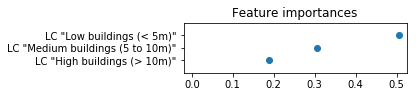

In [475]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

## Test D

In [474]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [ ]:
# Name of test
test = 'D'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = []  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [ ]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

## Test E

In [ ]:
# Name of test
test = 'E'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['111','112','113']  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [ ]:
import rf_model

In [ ]:
reload(rf_model)

In [ ]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [ ]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

## Test F

In [476]:
# Name of test
test = 'F'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['999']  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST F --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 999 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_999_proportion
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_f

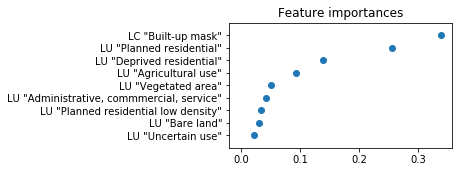

In [480]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

## Test G

In [490]:
# Name of test
test = 'G'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = []  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = ['1']  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = mr_builtup
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['1']

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST G --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: None 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: 1 
Layer 'MR_builtup' used to force zero weights when proportion of class '1' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion
MR_1_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_featur

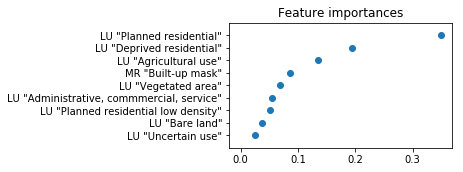

In [487]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

## Test H

In [491]:
# Name of test
test = 'H'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [ ]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

## Test I

In [492]:
# Name of test
test = 'I'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = ['1']  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [ ]:
# Run the random forest model
function_log = RandomForest(output_weighting_layer,gridded_vector.split("@")[0],
                            'cat', lc_classes, lu_classes, mr_classes,
                            layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

# Reallocate the population count using weighting layer

In [ ]:
# Name of the layer containing the population count to disagregate
print "Vector layer containing the variable to disagregate : '%s'"%gridded_vector
print "Attribute column containing the variable : '%s'"%population_column

In [ ]:
# Export weighing layers
for test in ['A','B','C','D','E','F','G','I']:
    outputfolder = os.path.join(outputdirectory_results,"Test_%s"%test)
    if not os.path.exists(outputfolder):  #Create folder where to save the plot if not exists
        os.makedirs(outputfolder)
    weight_raster = "Test_%s_weight"%test
    predict_raster = "Test_%s_prediction"%test   
    gscript.run_command('v.area.weigh', overwrite=True, quiet=True, vector=gridded_vector, 
                        column=population_column, weight=weight_raster, output=predict_raster)

# Validation

## Create gridded version of administratives units of level 1

In [ ]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [ ]:
# Create layer with boundaries corresponding to the grid 
admin_validation_level1_gridded = gridded_admin_boundaries("admin_level1", 'dissolve_i', 
                                                           population_column, clumped_grid)[1]

## Prediction accuracy assessment

In [ ]:
test = 'E'
prediction_raster_pop = 'Test_%s_prediction'%test
output_csv_validation = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s/attribute_table_validation.csv"%test
output_log_validation = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s/log_validation.txt"%test

In [ ]:
def get_ref_and_prediction_table(grid_layer, vector_admin_layer, ref_column, pop_column, prediction_raster_pop):
    # Define region to match the resolution and extend of the grid layer
    gscript.run_command('g.region', raster=grid_layer)  
    # Create raster with administrative unit ids
    reference_raster_id = random_layer_name()
    reference_raster_pop = random_layer_name()
    gscript.run_command('v.to.rast', overwrite=True, quiet=True, input=vector_admin_layer,
                        output=reference_raster_id, use='attr', attribute_column=ref_column)
    gscript.run_command('v.to.rast', overwrite=True, quiet=True, input=vector_admin_layer, 
                        output=reference_raster_pop, use='attr', attribute_column=pop_column)
       
    #Get id for each administrative zones in a list
    tmp_file = gscript.tempfile()
    gscript.run_command('r.univar', flags='et', overwrite=True, map=reference_raster_id, 
                        zones=reference_raster_id, output=tmp_file, separator='comma')
    fin = open(tmp_file)
    fin.next()
    id_list = [int(row.split(",")[4]) for row in fin] #4 refers to r.univar output for 'min' stat
    
    #Get the reference population count for each administrative zones in a list
    tmp_file=gscript.tempfile()
    gscript.run_command('r.univar', flags='et', overwrite=True, map=reference_raster_pop, 
                        zones=reference_raster_id, output=tmp_file, separator='comma')
    fin = open(tmp_file)
    fin.next()
    ref_list = [float(row.split(",")[4]) for row in fin] #4 refers to r.univar output for 'min' stat

    #Get the sum of prediction of population for each administrative zones in a list
    tmp_file=gscript.tempfile()
    gscript.run_command('r.univar', flags='et', overwrite=True, map=prediction_raster_pop, 
                        zones=reference_raster_id, output=tmp_file, separator='comma')
    fin = open(tmp_file)
    fin.next()
    predict_list = [float(row.split(",")[12]) for row in fin] #12 refers to r.univar output for 'sum' stat
    
    return pd.DataFrame({'Id':id_list,'Reference':ref_list,'Prediction':predict_list})

In [ ]:
def compute_validation_statistics(df, output_csv=""):
    #### Compute validation statistics for each administrative unit ####
    #Compute error
    df['error'] = df['Prediction']-df['Reference']
    #Compute percentage error raster
    df['prcterror'] = df['error']/df['Reference']*100
    #Compute squared error raster
    df['sqerror'] = df['error']**2
    #Compute absolute error raster
    df['abserror'] = abs(df['error'])
   
    if output_csv:
        df.to_csv(output_csv, index=False)

In [ ]:
import math as ma

def validation(grid_layer, vector_admin_layer, ref_column, pop_column, 
               prediction_raster_pop, output_csv='', output_log=''):
    ## Get a dataframe with unit 'id', reference value and predicted value
    df = get_ref_and_prediction_table(grid_layer, vector_admin_layer, 
                                      ref_column, pop_column, prediction_raster_pop)
    ## Compute validation statistics for each administrative unit
    compute_validation_statistics(df,output_csv)
    
    #### Compute overall validation statistics ####
    rmse = ma.sqrt(round(df['sqerror'].mean(),2))  #Compute RMSE (Root mean squared error)
    mean_ref = df['Reference'].mean()  #Compute mean reference population per admin unit
    prct_rmse = (rmse/mean_ref)*100  #Compute %RMSE (Root mean squared error in percentage of the mean reference population by grid)
    MAE = df['abserror'].mean()  #Compute MAE (Mean absolute error)
    TAE = df['abserror'].sum()  #Compute TAE (Total absolute error)
    POPTOT = df['Reference'].sum() #Compute Total reference population
    PREDTOT = df['Prediction'].sum() #Compute Total reference population
    RTAE = TAE/POPTOT  #Compute RTAE (Relative total absolute error)
    corr = np.corrcoef(df['Reference'],df['Prediction'])[0,1]  #Get correlation value
    r_squared = (corr**2)  #Get r² value    

    #### Outputs print and log
    function_log = "-------------- TEST %s --------------\n"%testlabel
    function_log+="Reference vector : %s \n"%vector_admin_layer.split("@")[0]
    function_log+="Prediction raster : %s \n"%prediction_raster_pop.split("@")[0]
    function_log+="\n"
    function_log+="Total reference population = %s \n"%round(POPTOT,1)
    function_log+="Total predicted population = %s \n"%round(PREDTOT,1)
    function_log+="Number of reference admin zones = %s \n"%df['Reference'].count()
    function_log+="Number of validation admin zones = %s \n"%df['Prediction'].count()
    function_log+='\n'
    function_log+="Mean reference population count per administrative unit = %s \n"%round(mean_ref,3)
    function_log+="Mean absolute error of prediction (MAE) = %s \n"%round(MAE,3)
    function_log+="Root mean squared error of prediction (RMSE) = %s \n"%round(rmse,3)
    function_log+="Root mean squared error of prediction in percentage (Percent_RMSE) = %s \n"%round(prct_rmse,3)
    function_log+="Total absolute error (TAE) = %s \n"%round(TAE,3)
    function_log+="Relative total absolute error (RTAE) = %s \n"%round(RTAE,3)
    function_log+="R squared = %s \n"%round(r_squared,3)
    if output_log:
        fout = open(output_log, 'w')
        fout.write(function_log)
        fout.close()
    
    ## Return
    return df, function_log

In [ ]:
df, function_log = validation(clumped_grid, admin_validation_level1_gridded,
                              'cat', population_column, prediction_raster_pop, 
                              output_csv=output_csv_validation, output_log=output_log_validation)

In [ ]:
df.tail()

In [ ]:
print function_log

# Export log file

In [ ]:
## Export the log file
end_time=time.ctime()
logging=open(log_file+'.txt', 'w')
logging.write('Log file of r.population.density\n')
logging.write('Run started on '+str(start_time)+' and finished on '+str(end_time)+'\n')
logging.write('Selected spatial resolution for weighting layer : '+tile_size+' meters\n')
logging.write('Administrative layer used : '+vector+'\n')
logging.write(log_text)
if flags['f'] :
    logging.write("\n")
    logging.write(log_text_extend)
logging.close()

In [ ]:
print log_text

# Export layers for archive or visualisation in another GIS

## VHR binary layers

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Binary_rasters'
if not os.path.exists(output_folder):  #Create folder if not exists
    os.makedirs(output_folder)
# Export all binary raster
for binary_raster in TMP_BINARIES:
    output_file = os.path.join(output_folder,'Dakar_binary_%s.tiff'%binary_raster)
    gscript.use_temp_region()  # Define temp region
    gscript.run_command('g.region', raster=binary_raster)
    gscript.run_command('r.out.gdal', overwrite=True, input=binary_raster, 
                        output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
    gscript.del_temp_region() # Remove temp region

## VHR built-up masks (combination of different built-up classes)

**Export of the layers**

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Binary_rasters'
if not os.path.exists(output_folder):  #Create folder if not exists
    os.makedirs(output_folder)
# Export all binary raster
for raster_layer in [VHR_builtup_classes, VHR_builtup_mask]:
    output_file = os.path.join(output_folder,'Dakar_%s.tiff'%raster_layer)
    gscript.use_temp_region()  # Define temp region
    gscript.run_command('g.region', raster=raster_layer)
    gscript.run_command('r.out.gdal', overwrite=True, input=raster_layer, 
                        output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
    gscript.del_temp_region() # Remove temp region

## Clumped Grid

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Clumped_grid'
if not os.path.exists(output_folder):  #Create folder if not exists
    os.makedirs(output_folder)
# Export clumped grid
output_file = os.path.join(output_folder,'Dakar_%s.tiff'%clumped_grid)
gscript.use_temp_region()  # Define temp region
gscript.run_command('g.region', raster=clumped_grid)
gscript.run_command('r.out.gdal', overwrite=True, input=clumped_grid, 
                    output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
gscript.del_temp_region() # Remove temp region

## Gridded administrative units (level0)

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation'
# Export gridded admin units (level0)
output_file = os.path.join(output_folder,'Dakar_%s.shp'%gridded_vector)
gscript.run_command('v.out.ogr', overwrite=True, flags='m', type='area', 
                    input=gridded_vector, output=output_file, format='ESRI_Shapefile')

## Weighting (RF output) and prediction layer - (all tests)

In [ ]:
# Export weighing layers
for test in ['A','B','C','D','E','F','G']:
    outputfolder = os.path.join(outputdirectory_results,"Test_%s"%test)
    if not os.path.exists(outputfolder):  #Create folder where to save the plot if not exists
        os.makedirs(outputfolder)
    layer = "Test_%s_weight"%test
    output_file = os.path.join(outputfolder,layer+'.tiff')
    gscript.run_command('r.out.gdal', overwrite=True, input=layer, 
                        output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
    layer = "Test_%s_prediction"%test 
    output_file = os.path.join(outputfolder,layer+'.tiff')
    gscript.run_command('r.out.gdal', overwrite=True, input=layer, 
                        output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')

# Cleaning mapset

In [497]:
print "Cleaning mapset from temporary layers..."
for raster_layer in TMP_MAPS:
    gscript.run_command('g.remove', flags='f', type='raster', name=raster_layer)

Cleaning mapset from temporary layers...
